# Teste

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
import random
import torch

from bayesian_nn import BayesianNN
from nn_methods import NeuralNetworkMethods

In [2]:
%matplotlib inline

## Carregando o Dataset

In [3]:
dataset = pd.read_csv('dataset/pima.csv')
dataset

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


### Normalização da base de dados e separação em treino e teste

São gerados vários _datasets_ a partir do original, cada um contendo a quantidade de dados de entrada que a rede neural suporta. Antes, os dados são normalizados através do `MinMaxScaler()` e cada _dataset_ é subdividido em _batches_ para serem enviados ao modelo do _Pytorch_. Também há, nessa etapa, a separação dos dados em treino e teste, feita de maneira aleatória com o `random_shuffle()`.

In [4]:
random.seed(30)
min_max_scaler = MinMaxScaler()
values = dataset.values
random.shuffle(values)
normalized_X = min_max_scaler.fit_transform(values[:,0:-1])
y = values[:,-1]
batched_datasets = []

for i in range(3,9,1):
    X_new = SelectKBest(chi2, k=i).fit_transform(normalized_X, y)
    dataset_values = np.split(X_new, 48)
    dataset_labels = np.split(y.astype(int), 48)
    batched_dataset = []
    for i in range(len(dataset_labels)):
        batched_dataset.append([torch.tensor(dataset_values[i]), torch.tensor(dataset_labels[i])])
    train_data = batched_dataset[:30]
    test_data = batched_dataset[30:]
    batched_datasets.append({'train': train_data, 'test': test_data})
    
#dataset_values = np.split(min_max_scaler.fit_transform(dataset.values[:,0:-1].astype(float)), 48)
#dataset_labels = np.split(dataset.values[:,-1].astype(int), 48)


## Criando as Redes Neurais

As redes neurais são criadas aqui, através do modelo definido no arquivo `nn_methods.py`.

In [5]:
neural_networks = []
for i in range(3,9,1):
    neural_networks.append(NeuralNetworkMethods(i,4,2,i-2))

## Treinando

Cada _batch_ é usado para treinar a rede 100 vezes.

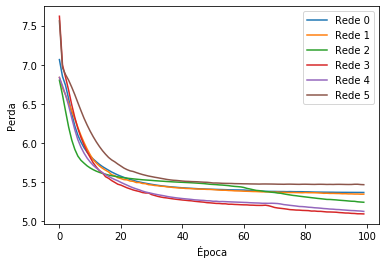

In [6]:
for i in range(len(neural_networks)):
    dataset_size = len(batched_datasets[i]['train']) + len(batched_datasets[i]['test'])
    losses = neural_networks[i].train(batched_datasets[i]['train'], dataset_size, 100)
    plt.plot(range(100), losses, label=("Rede " + str(i)))
    #plt.title("Rede " + str(i))
plt.legend(loc='upper right')
plt.xlabel("Época")
plt.ylabel("Perda")
plt.show()

## Testando

Para cada rede neural gerada, o teste é feito, uma vez ignorando e outra considerando o limiar de erros.

Rede 0
Acuracia quando a rede é obrigada a classificar: 75 %
Acuracia quando a rede pode recusar-se a classificar: 87 %
Porcentagem de predições 35 %
Rede 1
Acuracia quando a rede é obrigada a classificar: 72 %
Acuracia quando a rede pode recusar-se a classificar: 86 %
Porcentagem de predições 30 %
Rede 2
Acuracia quando a rede é obrigada a classificar: 75 %
Acuracia quando a rede pode recusar-se a classificar: 89 %
Porcentagem de predições 34 %
Rede 3
Acuracia quando a rede é obrigada a classificar: 73 %
Acuracia quando a rede pode recusar-se a classificar: 87 %
Porcentagem de predições 36 %
Rede 4
Acuracia quando a rede é obrigada a classificar: 78 %
Acuracia quando a rede pode recusar-se a classificar: 92 %
Porcentagem de predições 38 %
Rede 5
Acuracia quando a rede é obrigada a classificar: 71 %
Acuracia quando a rede pode recusar-se a classificar: 92 %
Porcentagem de predições 24 %


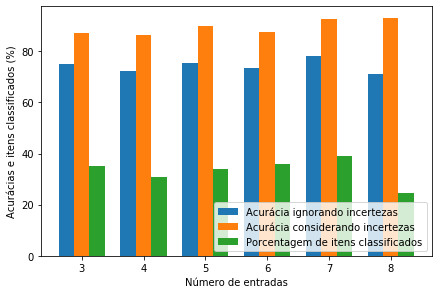

In [9]:
labels_network = ['3','4', '5','6','7','8']
accurs_1 = []
accurs_2 = []
percentages = []

for i in range(len(neural_networks)):
    print("Rede %d" % i)
    correct = 0
    total = 0
    for j, data in enumerate(batched_datasets[i]['test']):
        atributes, labels = data
        predicted = neural_networks[i].predict(atributes.float(), 200)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accur_1 = 100 * correct / total
    print("Acuracia quando a rede é obrigada a classificar: %d %%" % accur_1)
    
    correct = 0
    total = 0
    total_predicted_for = 0
    for j, data in enumerate(batched_datasets[i]['test']):
        atributes, labels = data
        total_minibatch, correct_minibatch, predictions_minibatch = neural_networks[i].test_batch(
            atributes.float(),
            labels,
            100,
            0.8
        )
        total += total_minibatch
        correct += correct_minibatch
        total_predicted_for += predictions_minibatch
    accur_2 = 0
    if(total_predicted_for > 0):
        accur_2 = 100 * correct / total_predicted_for
    
    accurs_1.append(accur_1)
    accurs_2.append(accur_2)
    percentages.append((100 *total_predicted_for/ total))
    print("Acuracia quando a rede pode recusar-se a classificar: %d %%" % accur_2)
    print("Porcentagem de predições %d %%" % (100 *total_predicted_for/ total))

location = np.arange(len(neural_networks))
width = 0.25
fig, ax = plt.subplots()
rects1 = ax.bar(location - width, accurs_1, width, label='Acurácia ignorando incertezas')
rects2 = ax.bar(location, accurs_2, width, label='Acurácia considerando incertezas')
rects3 = ax.bar(location + width, percentages, width, label='Porcentagem de itens classificados')

ax.set_xticks(location)
ax.set_xticklabels(labels_network)
ax.legend(loc='lower right')


fig.tight_layout()
plt.xlabel("Número de entradas")
plt.ylabel("Acurácias e itens classificados (%)")

plt.show()